In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import scipy.stats
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs, plot_T_x
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj, plot_contrast_response, \
                     get_Fano, load_SSSN_variable, get_stddev_sigma
from scipy.io import loadmat
import os

In [2]:
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "/Users/sbittner/Documents/git_repos/dsn_talk/epi_figs/SSSN/"

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

data = loadmat(os.path.join("data", "AgosBiorxiv2.mat"))['data']

inds = [62]
dt = 0.0005
T = 200
T_plot = 250

### 1. Show fit compared to data.

(6,) (6, 1, 8)
/Users/sbittner/Documents/git_repos/dsn_talk/epi_figs/SSSN/Fig3/fit.png


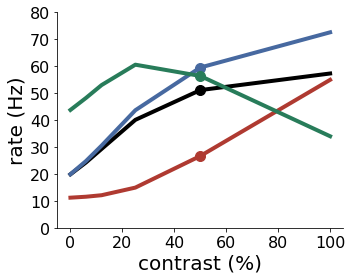

In [3]:
for ind in inds:
    W_mat = load_SSSN_variable('W', ind=ind)
    hb = load_SSSN_variable('hb', ind=ind)
    hc = load_SSSN_variable('hc', ind=ind)

    sssn_sim = SSSN_sim(0., W_mat, dt=dt, T=T_plot)

    fig, ax = plt.subplots(1,1, figsize=(5,4))
    c_points = np.array([0.5])
    hs = hb[None,:] + c_points[:,None]*hc[None,:]
    x_ss_points = sssn_sim(hs).numpy()
    plot_contrast_response(c_points, 100*x_ss_points[:,0,:], colors=colors, linestyle='o', ax=ax)
    
    c = np.array([0., 0.06, 0.12, 0.25, 0.5, 1.])
    hs = hb[None,:] + c[:,None]*hc[None,:]
    x_ss = sssn_sim(hs).numpy()
    print(c.shape, x_ss.shape)
    plot_contrast_response(c, 100*x_ss[:,0,:], colors=colors, ax=ax, fontsize=20)
    
    if ind == 62:
        fname = os.path.join(figdir, "Fig3", "fit.png")
    print(fname)
    plt.tight_layout()
    #plt.savefig(fname)

### 2. Calculate equivalence class for greater rates.  Check factor increase of k=100.

In [4]:
print(hb, hc)

tf.Tensor([0.41588497 0.4286093  0.4907676  0.4861505 ], shape=(4,), dtype=float32) tf.Tensor([0.35919505 0.40300423 0.         0.        ], shape=(4,), dtype=float32)


W fit
tf.Tensor(
[[ 2.1781893e+00 -1.1870320e+00 -5.9459770e-01 -2.2886373e-01]
 [ 1.6559428e+00 -6.5134937e-01 -6.7955399e-01 -2.4190041e-01]
 [ 8.9537537e-01 -5.2245674e-03 -1.5110424e-04 -7.6099437e-01]
 [ 3.3443694e+00 -2.3140862e+00 -2.5393552e-01 -2.5296208e-04]], shape=(4, 4), dtype=float32)

h fit
tf.Tensor([0.59548247 0.63011146 0.4907676  0.4861505 ], shape=(4,), dtype=float32)

W adjusted
tf.Tensor(
[[ 2.1781895e-01 -1.1870320e-01 -5.9459776e-02 -2.2886375e-02]
 [ 1.6559428e-01 -6.5134943e-02 -6.7955405e-02 -2.4190044e-02]
 [ 8.9537539e-02 -5.2245677e-04 -1.5110425e-05 -7.6099440e-02]
 [ 3.3443698e-01 -2.3140863e-01 -2.5393555e-02 -2.5296211e-05]], shape=(4, 4), dtype=float32)

h adjusted
tf.Tensor(
[[5.9548244]
 [6.3011146]
 [4.9076757]
 [4.861505 ]], shape=(4, 1), dtype=float32)


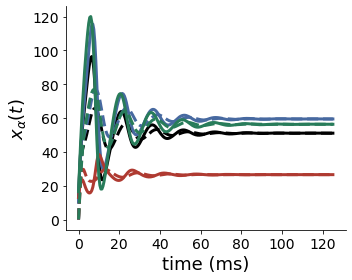

In [5]:
def get_equivalence(k, W_mat, h, n=2):
    D = W_mat.shape[0]
    A = k*tf.eye(D)
    W_mat_new = tf.matmul(tf.matmul(A, W_mat), tf.linalg.inv(A)**n)
    h_new = tf.matmul(A, h)
    return A, W_mat_new, h_new

k = 100

W_mat = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

contrast = 0.5
h = hb+contrast*hc

A_k, W_mat_k, h_k = get_equivalence(10., W_mat, h[:,None])
print('W fit')
print(W_mat)
print('\nh fit')
print(h)

print('\nW adjusted')
print(W_mat_k)
print('\nh adjusted')
print(h_k)

alphas = ['E', 'P', 'S', 'V']
fontsize=18
t = dt*np.arange(T_plot+1)

_h = h[None,:]
_h_k = h_k[None,:,0]

fig, ax = plt.subplots(1,1, figsize=(5,4))

np.random.seed(1)
sssn_sim_traj = SSSN_sim_traj(np.zeros((1,4)), W_mat, dt=dt, T=T_plot)
sssn_sim_traj_k = SSSN_sim_traj(np.zeros((1,4)), W_mat_k, dt=dt, T=T_plot)

r_t1 = np.dot(A_k**2, sssn_sim_traj(_h)[0,0,:4])
r_t2 = sssn_sim_traj_k(_h_k)[0,0,:4]
for neuron in alphas:
    j = neuron_inds[neuron]
    label_det = ''
    ax.plot(1e3*t, r_t1[j], '-', c=colors[j], 
             lw=3, label=label_det)
    ax.plot(1e3*t, r_t2[j], '--', c=colors[j], 
             lw=3, label='')
plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
ax.set_xlabel('time (ms)', fontsize=fontsize)
ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
plt.tight_layout()
plt.show()

### 3. Show the paradoxical effect.

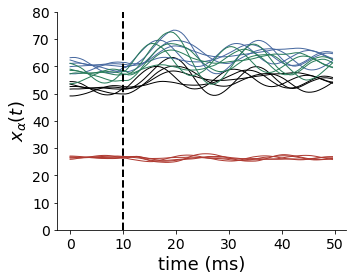

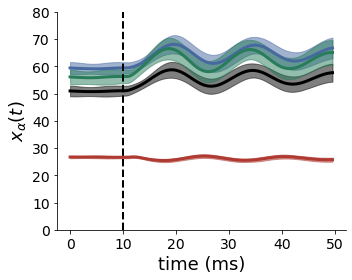

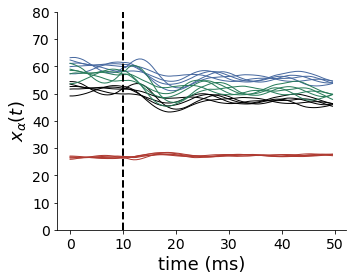

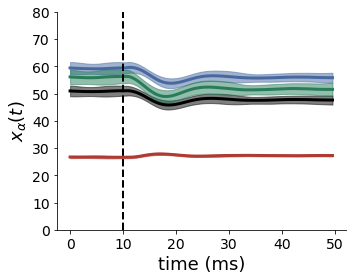

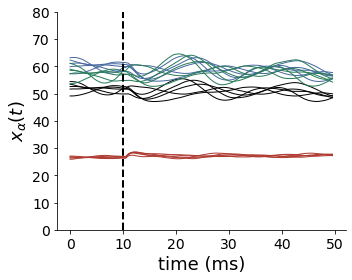

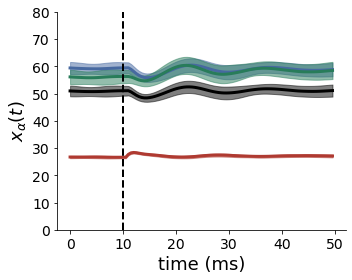

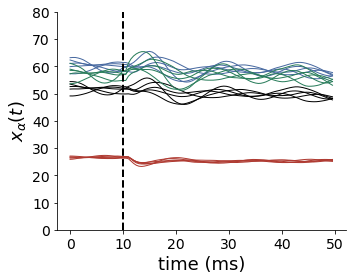

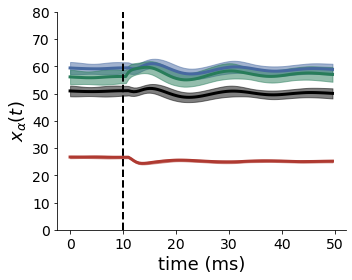

In [6]:
contrast = 0.5
alphas = ['E', 'P', 'S', 'V']
fontsize=18
ind = 62
dh_vals = [0.002, 0.002, 0.02, 0.02]
N_plot = 5
N = 50
sigma_eps = 0.5e-3*np.ones((1,4))
for dh_type, dh_val in zip(alphas, dh_vals):
    np.random.seed(0)
    tf.random.set_seed(0)
    W_mat = load_SSSN_variable('W', ind=ind)
    hb = load_SSSN_variable('hb', ind=ind)
    hc = load_SSSN_variable('hc', ind=ind)
    sssn_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=N, dt=dt, T=T_plot)
    h = (hb + contrast*hc)[None,:]
    
    r_t1 = sssn_sim_traj(h)[0,:,:4]
    
    x_init = r_t1[:,:,-1][None,:,:]
    sssn_PE_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=N, dt=dt, T=T_plot, x_init=x_init)
    
    dh = np.zeros((1,4))
    dh[0,neuron_inds[dh_type]] = dh_val
    r_t2 = sssn_PE_sim_traj(h+dh)[0,:,:4]
   
    start_ind = 230
    end_ind = 330
    r_t = tf.concat((r_t1, r_t2), axis=2).numpy()[:,:,start_ind:end_ind]
    t_stim = (T_plot-start_ind)*dt
    t = dt*np.arange(r_t.shape[2])
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    for neuron in alphas:
        j = neuron_inds[neuron]
        label_det = ''
        ax.plot(1e3*t, 100*r_t[:N_plot,j,:].T, '-', c=colors[j], 
                 lw=1, label=label_det)
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.plot([t_stim*1e3,t_stim*1e3], [0,80], 'k--')
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
    ax.set_ylim([0., 80.])
    plt.tight_layout()
    #plt.savefig(os.path.join(figdir, "FigV1_1", "sims_dh=%s.png" % dh_type))
    plt.show()
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    for neuron in alphas:
        j = neuron_inds[neuron]
        label_det = ''
        _mean = 100*np.mean(r_t[:,j,:], axis=0)
        _std = 100*np.std(r_t[:,j,:], axis=0)
        ax.fill_between(1e3*t, _mean-_std, _mean+_std, color=colors[j], alpha=0.5)
        ax.plot(1e3*t, _mean, '-', lw=3, c=colors[j])
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.plot([t_stim*1e3,t_stim*1e3], [0,80], 'k--')
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
    ax.set_ylim([0., 80.])
    plt.tight_layout()
    #plt.savefig(os.path.join(figdir, "FigV1_1", "stats_dh=%s.png" % dh_type))
    plt.show()
    

### 3.1 Load epi distribution.

In [8]:
f_means = [5., 10.]
f_std = 1.
alpha = 'E'

D = 4
lb = np.zeros((D,))
ub = 0.005*np.ones((D,))
sigma_eps = Parameter("sigma_eps", D, lb=lb, ub=ub)

dists = []
for f_mean in f_means:
    name = "SSSN_stddev_sigma_%s_%.2E_%.2E_ind=%d" % (alpha, f_mean, f_std, ind)
    parameters = [sigma_eps]
    model = Model(name, parameters)

    dt = 0.0005
    T = 200
    N = 50

    stddev = get_stddev_sigma('E', W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=f_mean)
    model.set_eps(stddev)

    epi_df = model.get_epi_df()

    epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
    epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
    epi_df['elemwise_fn'] = ['affine' if 'affine' in path else 'spline' for path in epi_df['path']]
    epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
    epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
    epi_df['f_mean'] = [ep['mu'][0] for ep in epi_df['EP']]
    epi_df['f_std'] = [np.sqrt(ep['mu'][1]) for ep in epi_df['EP']]
    epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

    epi_df = epi_df[(epi_df['f_std']==f_std) & 
                    (epi_df['c0']==1e-1) & 
                    (epi_df['random_seed'] == 1)]

    best_k = epi_df['k'].max()
    df_row = epi_df.iloc[0]
    dists.append(model.get_epi_dist(df_row, k=int(best_k)))


### 3.2 Plot epi distribution.

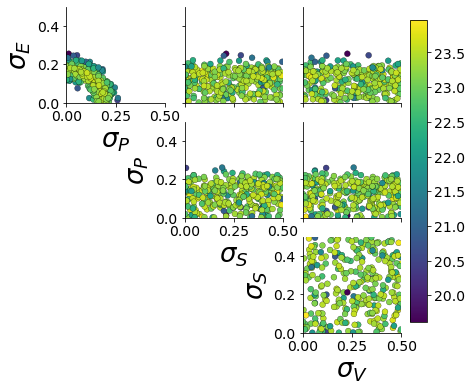

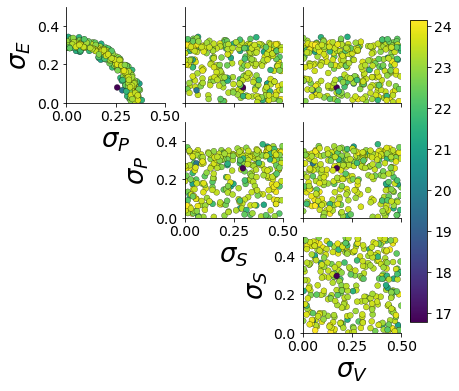

In [43]:
M = 300
num_plot = 300
zs = []
log_q_zs = []
T_xs = []
alphas = ['E', 'P', 'S', 'V']
z_labels = [r'$\sigma_%s$' % alpha for alpha in alphas]
for dist in dists:
    np.random.seed(1)
    tf.random.set_seed(1)
    z, log_q_z = dist.nf(M)
    z, log_q_z = z.numpy(), log_q_z.numpy()
    zs.append(z)
    log_q_zs.append(z)
    T_xs.append(model.eps(z).numpy())

    z_mode = z[np.argmax(log_q_z), :][None,:]

    fig = pairplot(1e2*z[:num_plot], np.arange(4), z_labels,
                   fontsize=26, figsize=(6,6), ticksize=14, s=35, c_label='', 
                   lb=lb, ub=1e2*ub, c=log_q_z[:num_plot])
    #plt.savefig(os.path.join(figdir, "Fig3", "PanelD.png"))
    plt.show()

/Users/sbittner/Documents/epi/epi/util.py:766: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([0.92, 0.15, 0.04, 0.7])


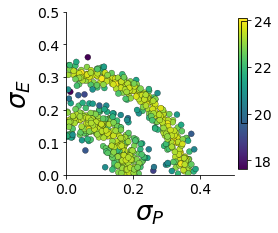

In [41]:
np.random.seed(1)
tf.random.set_seed(1)
dist = dists[0]
z, log_q_z = dist.nf(M)
z, log_q_z = z.numpy(), log_q_z.numpy()

fig, axs = pairplot(1e2*z[:num_plot], np.arange(2), z_labels,
               fontsize=26, figsize=(3,3), ticksize=14, s=35, c_label='', 
               lb=lb, ub=1e2*ub, c=log_q_z[:num_plot])

dist = dists[1]
z, log_q_z = dist.nf(M)
z, log_q_z = z.numpy(), log_q_z.numpy()
fig, axs = pairplot(1e2*z[:num_plot], np.arange(2), z_labels, subplots=(fig, axs),
               fontsize=26, figsize=(3,3), ticksize=14, s=35, c_label='', 
               lb=lb, ub=1e2*ub, c=log_q_z[:num_plot])
#plt.savefig(os.path.join(figdir, "Fig3", "PanelD.png"))
plt.show()

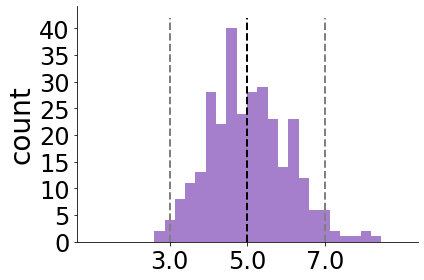

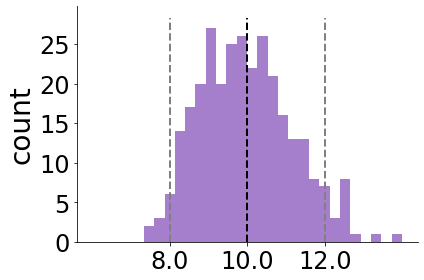

In [10]:
for f_mean, T_x in zip(f_means, T_xs):
    plot_T_x(None, T_x[:,0], bins=30, 
                 x_mean=f_mean, x_std=f_std, figsize=None,
                 xlabel='', ylim=None, fontsize=28)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "T_x_%dHz.png" % int(f_mean)), transparent=True)
    plt.show()

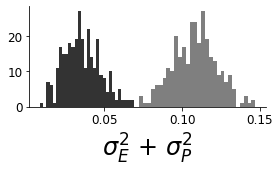

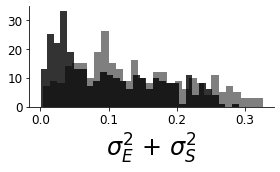

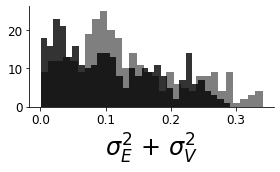

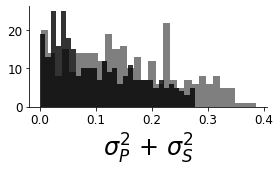

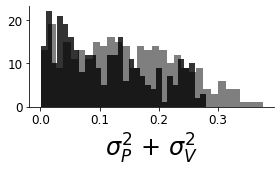

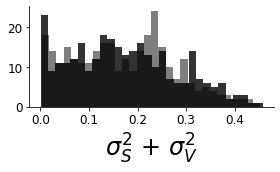

In [44]:
cs = [np.array([0., 0., 0., 0.8]), np.array([0., 0., 0., 0.5])]
_z_labels = ['$\sigma_%s^2$' % alpha for alpha in alphas]
for ii in range(4):
    for jj in range(ii+1, 4):
        plt.figure(figsize=(4,2.5))
        for i, z in enumerate(zs):
            _z = 100.*z
            f = _z[:,ii]**2 + _z[:,jj]**2
            plt.hist(f, color=cs[i], bins=30)
            plt.xlabel(_z_labels[ii] + ' + ' + _z_labels[jj], fontsize=24)
        plt.tight_layout()
        plt.savefig(os.path.join(figdir + "square_sum_%d%d" % (ii,jj)))
        plt.show()

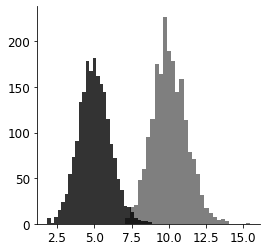

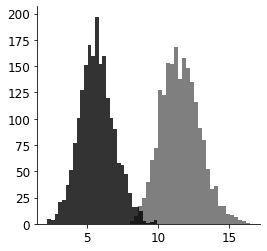

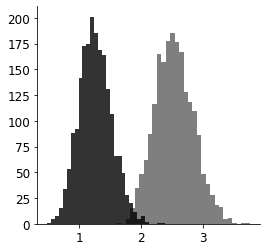

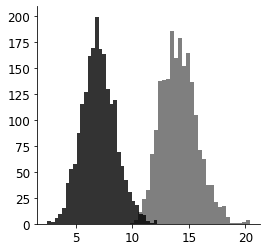

In [98]:
cs = [np.array([0., 0., 0., 0.8]), np.array([0., 0., 0., 0.5])]
stddevs = []
for alpha in alphas:
    fs = []
    plt.figure(figsize=(4,4))
    _stddevs = []
    for i, z in enumerate(zs):
        stddev = get_stddev_sigma(alpha, W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=f_mean)
        f = stddev(z).numpy()[:,0]
        _stddevs.append(f)
        plt.hist(f, color=cs[i], bins=30)
    plt.show()
    stddevs.append(_stddevs)

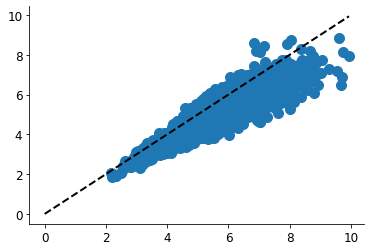

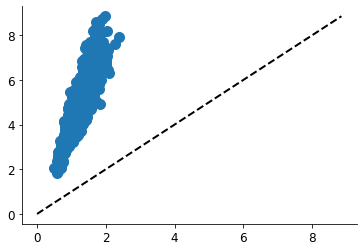

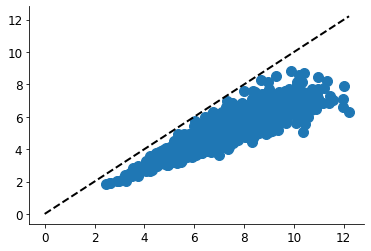

In [104]:
x = np.array([stddev[0] for stddev in stddevs]).T
for i in [1,2,3]:
    plt.figure()
    plt.scatter(x[:,i], x[:,0])
    _max = max(np.max(x[:,i]), np.max(x[:,0]))
    plt.plot([0,_max], [0, _max], 'k--')
    plt.show()

In [105]:
def get_conditional_mode(dist, alpha, val, step=1e-6, num_steps=100):
    ind = neuron_inds[alpha]
    z0_np = ((dist.nf.lb + dist.nf.ub) / 2.)
    z0_np[ind] = val
    z = tf.Variable(initial_value=z0_np[None,:], dtype=tf.float32, trainable=True)
    
    log_q_z = dist.log_prob(z.numpy())
    
    zs = [z]
    log_q_zs = [log_q_z]
    
    for k in range(num_steps):
        grad_z = dist._gradient(z).numpy()
        z_np = z.numpy()
        z_next = z_np + step * grad_z
        z_next[0,ind] = val
        for j in range(4):
            if z_next[0,j] < lb[j]:
                z_next[0,j] = lb[j]
            if z_next[0,j] > ub[j]:
                z_next[0,j] = ub[j]
        z = tf.Variable(initial_value=z_next, 
                        dtype=tf.float32, trainable=True)
        
        log_q_z = dist.log_prob(z_next)
        zs.append(z_next[0])
        log_q_zs.append(log_q_z)
        
    return zs, log_q_zs

dist = dists[1]
sigma_P_vals = np.arange(0.0005, 0.0021, 0.0005)
ridge_zs = []
ridge_log_q_zs = []
for sigma_P_val in sigma_P_vals:
    zs, log_q_zs = get_conditional_mode(dist, 'P', sigma_P_val, step=5.0e-9, num_steps=50)
    print(sigma_P_val, zs[-1])
    ridge_zs.append(zs[-1])
    ridge_log_q_zs.append(log_q_zs[-1])
    
ridge_zs = np.array(ridge_zs)
ridge_log_q_zs = np.array(ridge_log_q_zs)

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


0.0005 [0.00305568 0.0005     0.00248407 0.00250349]


0.001 [0.00298765 0.001      0.00249977 0.00251029]


0.0015 [0.00282126 0.0015     0.00249423 0.00248966]


0.002 [0.00257637 0.002      0.00249824 0.00247725]


In [108]:
print(ridge_zs)

[[0.00305568 0.0005     0.00248407 0.00250349]
 [0.00298765 0.001      0.00249977 0.00251029]
 [0.00282126 0.0015     0.00249423 0.00248966]
 [0.00257637 0.002      0.00249824 0.00247725]]


In [106]:
hess_z = dist.hessian(ridge_zs)
vs = []
for i, sigma_P_val in enumerate(sigma_P_vals):
    hess_z_i = hess_z[i]
    d, v = np.linalg.eig(hess_z_i)
    min_ind = np.argmin(d)
    _v = v[:,min_ind]
    if (_v[0] < 0.):
        _v = -_v
    vs.append(_v)
    
vs = np.array(vs)

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


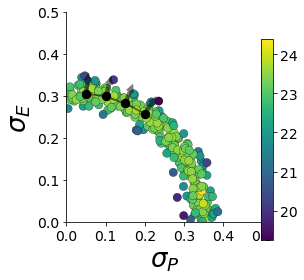

In [127]:
np.random.seed(0)
tf.random.set_seed(0)
_z, _log_q_z = dists[1].nf(300)
_z, _log_q_z = _z.numpy(), _log_q_z.numpy()
fig, ax = pairplot(1e2*_z, np.arange(2), z_labels, 
               fontsize=26, figsize=(4,4), ticksize=14, s=70,
               lb=lb, ub=0.5*np.ones((4,)), c=_log_q_z, c_label='')
ridge_color = np.array([0.,0.,0.,.5])
ax.scatter(1e2*ridge_zs[:,1], 1e2*ridge_zs[:,0], c='k', s=70)
ax.plot(1e2*ridge_zs[:,1], 1e2*ridge_zs[:,0], '-', c=ridge_color)
fac = 0.0005
for i, sigma_P_val in enumerate(sigma_P_vals):
    vx = 1e2*np.array([ridge_zs[i,1], ridge_zs[i,1]+fac*vs[i,1]])
    vy = 1e2*np.array([ridge_zs[i,0], ridge_zs[i,0]+fac*vs[i,0]])
    ax.annotate("", xy=[vx[1], vy[1]], xytext=[vx[0], vy[0]], 
                 arrowprops=dict(headwidth=8, headlength=8, lw=.25, color=ridge_color))
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelE_zoom.png"))

In [204]:
def sensitivity(stddev_f, z, v, fac_lim=0.005):
    facs = np.linspace(-fac_lim, fac_lim, 51)
    z_perturb = z + facs[:,None]*v
    T_x_perturb = stddev_f(z_perturb)
    d = np.abs(T_x_perturb[:,0] - f_mean)
    a, b, r, p, _ = scipy.stats.linregress(facs, d)
    return a, r

def rvs(D, N):
    v = np.random.normal(0., 1., (N,D))
    v = v / np.linalg.norm(v, axis=1)[:,None]
    return v

fac_lim = 0.0025
n_rand = 25
v_rands = rvs(4, n_rand)
bs = []
rs = []

alphas = ['E', 'P', 'S', 'V']
b_rands = []
r_rands = []
for i, sigma_P_val in enumerate(sigma_P_vals):
    z_i = ridge_zs[i][None]
    v_i = vs[i][None]
    _b_rands = []
    _r_rands = []
    for j, alpha in enumerate(alphas):
        print(i,j,alpha)
        stddev_f = get_stddev_sigma(alpha, W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=f_mean)
        _b, _r = sensitivity(stddev_f, z_i, v_i, fac_lim=fac_lim)
        bs.append(_b)
        rs.append(_r)
        _sens_rand = [sensitivity(stddev_f, z_i, v_rands[i][None,:], fac_lim=fac_lim)
                   for j in range(n_rand)]
        _b_rands.append(np.array([_sens_rand[j][0] for j in range(n_rand)]))
        _r_rands.append(np.array([_sens_rand[j][1] for j in range(n_rand)]))
    b_rands.append(_b_rands)
    r_rands.append(_r_rands)
b_rands = np.array(b_rands)
r_rands = np.array(r_rands)

0 0 E
0 1 P
0 2 S
0 3 V
1 0 E
1 1 P
1 2 S
1 3 V
2 0 E
2 1 P
2 2 S
2 3 V
3 0 E
3 1 P
3 2 S
3 3 V


In [206]:
dfs = []
for i, sigma_P_val in enumerate(sigma_P_vals):
    dfs.append(pd.DataFrame({'alpha':alphas, 'sigma_P_val':sigma_P_val, 'type':'hess', 'b':bs[(4*i):(4*(i+1))]}))
    for j, alpha in enumerate(alphas):
        dfs.append(pd.DataFrame({'alpha':alpha, 'sigma_P_val':sigma_P_val, 'type':'rand', 'b':b_rands[i][j]}))
df = pd.concat(dfs)
print(df)

   alpha  sigma_P_val  type            b
0      E       0.0005  hess   559.086816
1      P       0.0005  hess  2006.546702
2      S       0.0005  hess  -969.246280
3      V       0.0005  hess  3961.727033
0      E       0.0005  rand   205.073809
..   ...          ...   ...          ...
20     V       0.0020  rand -3090.236943
21     V       0.0020  rand -3095.838577
22     V       0.0020  rand -3347.005801
23     V       0.0020  rand -2790.830983
24     V       0.0020  rand -3405.968079

[416 rows x 4 columns]


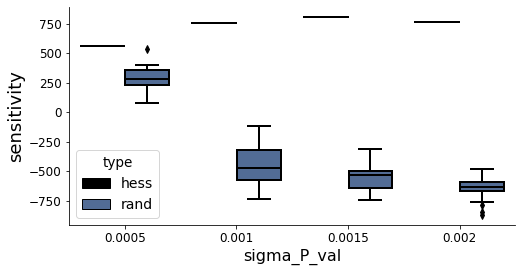

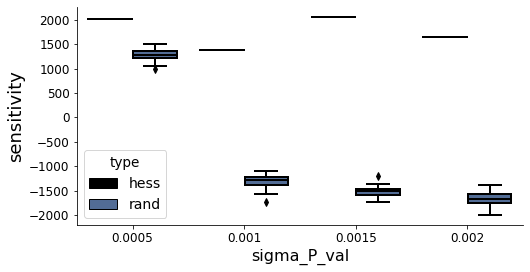

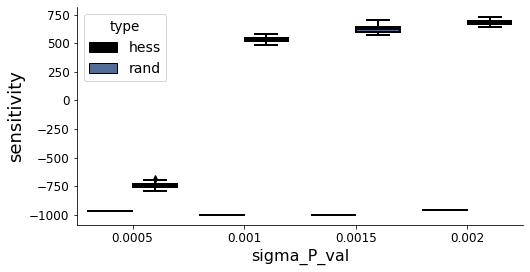

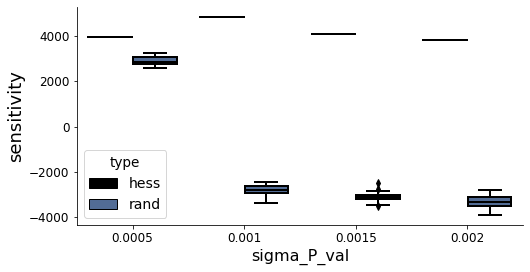

In [207]:
import seaborn as sns
for alpha in alphas:
    _df = df[df['alpha']==alpha]
    plt.figure(figsize=(8,4))
    ax = sns.boxplot(data=_df, x='sigma_P_val', y='b', hue='type', palette=colors)
    ax.set_ylabel('sensitivity', fontsize=18)
    plt.show()

#ax.scatter(sigma_P_vals, bs, c='k')
#ax = sns.boxplot(x=np.round(1e3*sigma_P_vals, 2), y=b_rands, color=.3*np.ones(3))
#ax.set_xlabel(r'$\sigma_P$', fontsize=fontsize)
#plt.setp(ax.get_xticklabels(), fontsize=ticksize)
#plt.setp(ax.get_yticklabels(), fontsize=ticksize)
#ax.set_ylim([-.1, .9])
#plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelE_sens.png"), transparent=True)

In [65]:
"""Fano_extra = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=300, T_ss=150, mu=ff_mean)
model.set_eps(Fano_extra)

T_x = model.eps(z).numpy()
plot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,
             x_mean=ff_mean, x_std=ff_std, figsize=None,
             xlabel=r'$F(x; z)$', ylim=None, fontsize=28)"""

"Fano_extra = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=300, T_ss=150, mu=ff_mean)\nmodel.set_eps(Fano_extra)\n\nT_x = model.eps(z).numpy()\nplot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,\n             x_mean=ff_mean, x_std=ff_std, figsize=None,\n             xlabel=r'$F(x; z)$', ylim=None, fontsize=28)"

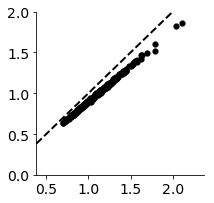

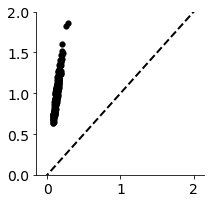

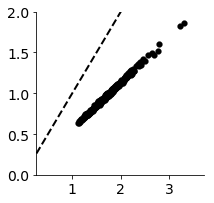

In [74]:
Fano_all = get_Fano_sigma('all', W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=ff_mean)
fano_all = Fano_all(z).numpy()

fano_labels = [r'$F_%s$' % alpha for alpha in alphas]
inhib_types = ['P', 'S', 'V']
for alpha in inhib_types:
    alpha_ind = neuron_inds[alpha]
    fano_E_alpha = np.stack((fano_all[:,0], fano_all[:,alpha_ind]), axis=1)
    fig, ax = pairplot(fano_E_alpha, np.arange(2), ['', ''],
                   fontsize=24, figsize=(3,3), ticksize=14, s=35,
                   lb=np.zeros(2,), ub=3.*np.ones((2,)), unity_line=True)
    ax.set_ylim([0., 2.])
    #plt.savefig(os.path.join(figdir, "Fig3", "PanelF_E%s.png" % alpha))
    plt.show()

In [90]:
#sigma_eps = np.array([[2.7747380e-02, 2.9908607e-02,  1.0897118e-03, 1.3312697e-05]])
sigma_eps = np.array([[0.00175, 0.00175, 0.002, 0.002]])

_c = np.linspace(0, 1, 25)

_N = 5
hs = hb[None,:] + _c[:,None]*hc[None,:]
F_means = []
F_stds = []
for m in range(200):
    sigma_eps = z[m,:][None,:]
    Fano = get_Fano('all', sigma_eps, W_mat, dt=dt, N=N, T=T)
    Fs = []
    for k in range(_N):
        print('m=%d: %2d/%2d \r' % (m+1, k+1, _N), end="")
        Fs.append(Fano(hs).numpy())
    Fs = np.array(Fs)
    F_means.append(np.mean(Fs, axis=0))
    F_stds.append(np.std(Fs, axis=0))

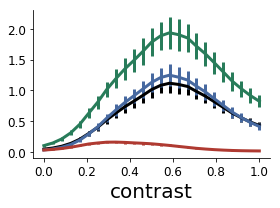

In [91]:
F_means = np.array(F_means)
F_stds = np.array(F_stds)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
fontsize= 20
for ii in range(4):
    ax.errorbar(_c, np.mean(F_means[:,:,ii], axis=0), 
                np.std(F_means[:,:,ii], axis=0), c=colors[ii], lw=3)
ax.set_xlabel('contrast', fontsize=fontsize)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelG.png"))
plt.show()

F_mean (10, 8)
F_std (10, 8)


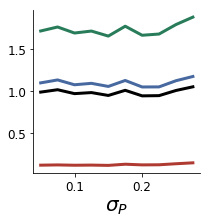

In [14]:
Ns = [50]
Ts = [150]
F_means = {}
F_stds = {}
_N = 50
for N in Ns:
    for T in Ts:
        Fano = get_Fano_sigma('all', W_mat, h, dt=dt, N=N, T=T)
        sigma_eps = ridge_zs
        Fs = []
        for k in range(_N):
            print('%2d/%2d \r' % (k+1, _N), end="")
            Fs.append(Fano(sigma_eps).numpy())
        Fs = np.array(Fs)
        F_means.update({(N,T): np.mean(Fs, axis=0)})
        F_stds.update({(N,T): np.std(Fs, axis=0)})

fig, axs = plt.subplots(len(Ns), len(Ts), figsize=(3,3))
fontsize= 20
for i, N in enumerate(Ns):
    for j, T in enumerate(Ts):
        if len(Ns) == 1:
            if len(Ts) == 1:
                ax = axs
            else:
                ax = axs[j]
        elif len(Ts) == 1:
            ax = axs[i]
        else:
            ax = axs[i,j]
        F_mean = F_means[(N,T)]
        F_std = F_stds[(N,T)]
        print('F_mean', F_mean.shape)
        print('F_std', F_std.shape)
        for ii in range(4):
            #plt.errorbar(_c, h_var[:,i], h_var[:,i+4], c=colors[i])
            #ax.errorbar(np.arange(5), F_mean[:,ii], F_std[:,ii], c=colors[ii])
            ax.plot(1e2*sigma_P_vals, F_mean[:,ii], c=colors[ii], lw=3)
            #plt.plot(_c, h_var[:,i], c=colors[i])
        if (i==(len(Ns)-1)):
            ax.set_xlabel(r'$\sigma_P$', fontsize=fontsize)
        #if (j==0):
            #ax.set_ylabel(r'$F(x; z)$', fontsize=fontsize)
        #ax.set_ylim([0, 0.05])
plt.show()


0.05345521893470395
198.12273 202.37111 0.33196604


(0, 0.003)

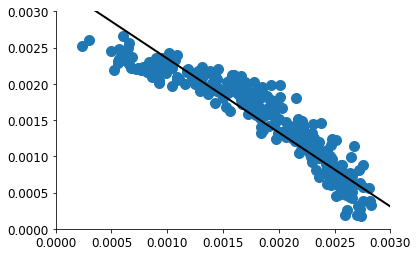

In [110]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(z[:,:2], T_x[:,0])
print(linreg.score(z[:,:2], T_x[:,0]))
a, b = linreg.coef_
c = linreg.intercept_
print(a,b,c)
x2 = np.linspace(0., 0.003, 7)
x1 = (1./a)*(-b*x2 - c + 1)
plt.figure()
plt.scatter(z[:,1], z[:,0])
plt.plot(x2, x1, 'k')
plt.xlim([0,.003])
plt.ylim([0,.003])

In [125]:
fano = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=1000, T_ss=500, mu=ff_mean)
model.set_eps(fano)
T_x2 = model.eps(z)

0.2013501684955349
183393.33 152147.11 -0.06324375


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


(0, 0.003)

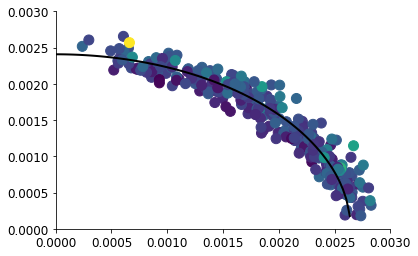

In [129]:
linreg = LinearRegression().fit(z[:,:2]**2, T_x[:,0])

print(linreg.score(z[:,:2]**2, T_x[:,0]))
a, b = linreg.coef_
c = linreg.intercept_
print(a,b,c)
x2 = np.linspace(0., 0.003, 100)
x1 = np.sqrt((1./a)*(-b*(x2**2) - c + 1.))
plt.figure()
plt.scatter(z[:,1], z[:,0], c=T_x[:,0])
plt.plot(x2, x1, 'k')
plt.xlim([0,.003])
plt.ylim([0,.003])

In [103]:
print(z)

[[0.0022198  0.00067846 0.00109395 0.00203018]
 [0.00212478 0.00130113 0.00465937 0.00251583]
 [0.0019276  0.00171507 0.00411682 0.00083306]
 ...
 [0.00200281 0.00116387 0.00074885 0.00303661]
 [0.00233102 0.0005979  0.00219432 0.00189279]
 [0.00194572 0.00145315 0.00206235 0.00164582]]
